In [1]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms as T
import os, shutil
from matplotlib import pyplot as plt
import sklearn as sk
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
import torchmetrics
import timm
from time import time
import random
torch.cuda.is_available()

True

In [2]:
import os, gdown 
from glob import glob
import shutil
def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "fruits"):

    data_nomlari = ["salaries", "exams", "college", "cars", "car_brands", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

data_yuklab_olish(saqlash_uchun_papka = "datasets", data_nomi = "fruits")
data_path = "datasets/fruits"

Dataset yuklab olingan. datasets/fruits papkasini ni tekshiring.


In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_path, data, transformations = None, img_formats = ['.png', '.jpg', '.jpeg', '.bmp']):
   
        self.img_pathes = [img_path for img_path in sorted(glob(f"{data_path}/{data}/*/*{[img_format for img_format in img_formats]}"))]
        self.transformations = transformations
        self.img_formats = img_formats
        self.data = data
        # self.class_name_detection()
        self.data_quantity = {}
        self.class_names = {}
        count = 0

        for idx, img_path in enumerate(self.img_pathes):
            class_name = self.class_name_detection(img_path)
            if class_name not in self.class_names:
                self.class_names[class_name] = count
                self.data_quantity[class_name] = 1
                count += 1
            else:
                self.data_quantity[class_name] += 1

    def __len__(self): return len(self.img_pathes)

    def class_name_detection(self, img_path):
        return os.path.dirname(img_path).split("/")[-1]

    def __getitem__(self, idx):
        img_path = self.img_pathes[idx]
        img = Image.open(img_path).convert("RGB")
        gt = self.class_names[self.class_name_detection(img_path)]
        if self.transformations: img = self.transformations(img)
        return (img, gt) if not self.data == "test" else img
def dataloaders(data_path, bs, transformations):
    
    tr_ds = CustomDataset(data_path = data_path, data="train", transformations=transformations)
    vl_ds = CustomDataset(data_path=data_path, data="val", transformations=transformations)
    ts_ds = CustomDataset(data_path=data_path, data="test", transformations=transformations)

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle = False)
    return tr_dl, vl_dl, ts_dl, tr_ds.class_names
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tfs = T.Compose([ T.Resize((224,224)), T.ToTensor(), T.Normalize(mean=mean, std = std) ])
tr_dl, vl_dl, ts_dl, class_names = dataloaders(data_path = data_path, bs= 64 , transformations = tfs)
print(len(tr_dl.dataset))
print(len(vl_dl.dataset))
print(len(ts_dl))
print(class_names)

40000
5000
5000
{'train\\abiu': 0, 'train\\acai': 1, 'train\\acerola': 2, 'train\\ackee': 3, 'train\\ambarella': 4, 'train\\apple': 5, 'train\\apricot': 6, 'train\\avocado': 7, 'train\\banana': 8, 'train\\barbadine': 9, 'train\\barberry': 10, 'train\\betel_nut': 11, 'train\\bitter_gourd': 12, 'train\\black_berry': 13, 'train\\black_mullberry': 14, 'train\\brazil_nut': 15, 'train\\camu_camu': 16, 'train\\cashew': 17, 'train\\cempedak': 18, 'train\\chenet': 19, 'train\\cherimoya': 20, 'train\\chico': 21, 'train\\chokeberry': 22, 'train\\cluster_fig': 23, 'train\\coconut': 24, 'train\\corn_kernel': 25, 'train\\cranberry': 26, 'train\\cupuacu': 27, 'train\\custard_apple': 28, 'train\\damson': 29, 'train\\dewberry': 30, 'train\\dragonfruit': 31, 'train\\durian': 32, 'train\\eggplant': 33, 'train\\elderberry': 34, 'train\\emblic': 35, 'train\\feijoa': 36, 'train\\fig': 37, 'train\\finger_lime': 38, 'train\\gooseberry': 39, 'train\\goumi': 40, 'train\\grape': 41, 'train\\grapefruit': 42, 'tra

### Visualization

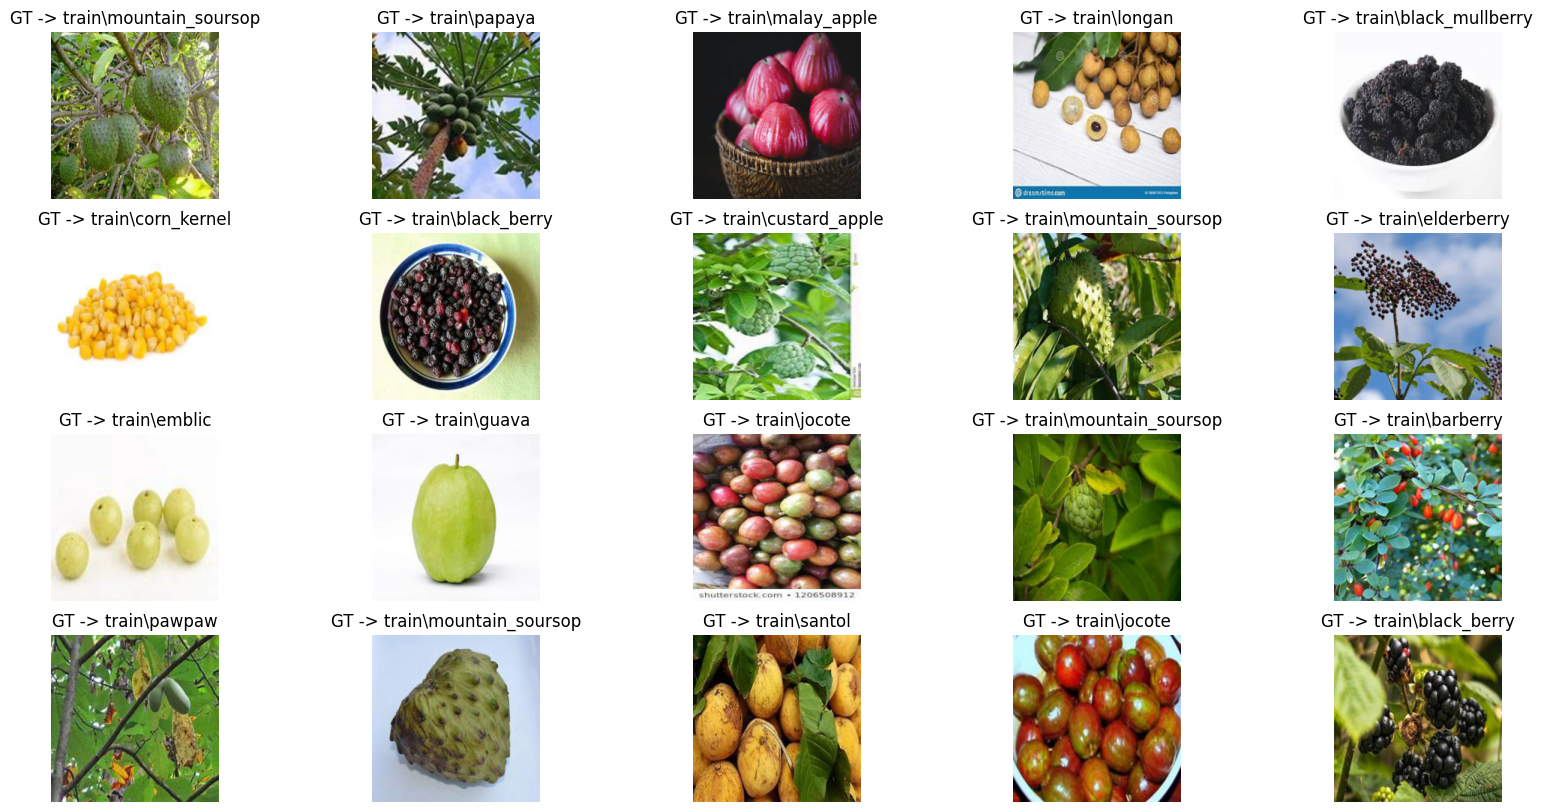

In [4]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, class_names = None, data_type = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        if data_type == "test": im = data[indeks] 
        else: im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if class_names is not None: plt.title(f"GT -> {class_names[int(gt)]}") if not data_type == "test" else plt.title(f"Test data has no pre-defined class")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(class_names.keys()))


### Train

In [5]:
from torch.nn import *
import timm
def model_train(tr_dl, model, loss_fn, optimizer, device):
    model.train()
    model.to(device)
    tr_loss, tr_acc = 0, 0

    for idx, batch in enumerate(tqdm(tr_dl, desc = "Train process...")):
        img, label = batch
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_classes = torch.argmax(pred, dim = 1)
        acc = (torch.sum(pred_classes == label).item()/len(label)) * 100
        tr_acc += acc/len(tr_dl)
        tr_loss += loss.item() / len(tr_dl)
    return tr_loss, tr_acc

def model_val(vl_dl, model, loss_fn, optimizer, device):
    model.eval()
    model.to(device)
    vl_loss, vl_acc = 0, 0
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(vl_dl, desc = "Validation process...")):
            img, label = batch
            img = img.to(device)
            label = label.to(device)
            pred = model(img)
            loss = loss_fn(pred, label)
    
            pred_classes = torch.argmax(pred, dim=1)
            acc = (torch.sum(pred_classes == label).item()/len(label)) * 100
            vl_acc += acc/len(vl_dl)
            vl_loss += loss.item() / len(vl_dl.dataset)

        return vl_loss, vl_acc

def train(model, tr_dl, vl_dl, loss_fn, optimizer, device, epochs, model_dir ="best_model"):
    os.makedirs(model_dir, exist_ok = True)
    best_acc = 0
    patience = 0
    train_losses, train_acces = [], []
    vl_losses, vl_acces = [], []

    for epoch in range(epochs):
        print(f"{epoch+1}/{epochs}")
        tr_loss, tr_acc = model_train(tr_dl, model, loss_fn, optimizer, device)
        vl_loss, vl_acc = model_val(vl_dl, model, loss_fn, optimizer, device)
        train_losses.append(tr_loss)
        train_acces.append(tr_acc)
        vl_losses.append(vl_loss)
        vl_acces.append(vl_acc)

        if vl_acc > best_acc:
            best_acc = vl_acc
            torch.save(model, os.path.join(model_dir, "_fruits_best_model.pth"))

        else: patience +=1
        if patience == 3:
            print(f"Best accuracy did not change during {patience} epochs. So EARLY STOPPING TRIGGERED!")
            print(f"Model/s best performance is - {best_acc}")
            break

        print(f"Train Loss -> {tr_loss:.2f}    | Train Accuracy -> {tr_acc:.2f}%")
        print(f"Val Loss   -> {vl_loss:.2f}    | Val Accuracy   -> {vl_acc:.2f}%")

    return train_losses, train_acces, vl_losses, vl_acces
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = timm.create_model("rexnet_150", pretrained = True, num_classes = len(class_names)).to(device)

# class_counts = torch.tensor(list(self.data_quantity.values()))  # Class sample counts
# weights1 = 1.0 / class_counts.float()  # Inverse frequency
# weights1 /= weights1.sum()
# weights1 = weights1.to(device)


optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4, weight_decay = 1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train_losses, train_acces, vl_losses, vl_acces = train(model = model, tr_dl = tr_dl, vl_dl= vl_dl, loss_fn=loss_fn, optimizer=optimizer, device = device, epochs = 50)

1/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:52<00:00,  1.42s/it]


Train Loss -> 1.31    | Train Accuracy -> 65.84%
Val Loss   -> 0.01    | Val Accuracy   -> 80.66%
2/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:54<00:00,  1.46s/it]


Train Loss -> 0.45    | Train Accuracy -> 85.82%
Val Loss   -> 0.01    | Val Accuracy   -> 82.30%
3/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:52<00:00,  1.42s/it]


Train Loss -> 0.26    | Train Accuracy -> 91.21%
Val Loss   -> 0.01    | Val Accuracy   -> 83.11%
4/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:56<00:00,  1.47s/it]


Train Loss -> 0.18    | Train Accuracy -> 94.03%
Val Loss   -> 0.01    | Val Accuracy   -> 83.76%
5/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:53<00:00,  1.43s/it]


Train Loss -> 0.15    | Train Accuracy -> 94.94%
Val Loss   -> 0.01    | Val Accuracy   -> 83.82%
6/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:55<00:00,  1.47s/it]


Train Loss -> 0.14    | Train Accuracy -> 95.41%
Val Loss   -> 0.01    | Val Accuracy   -> 83.11%
7/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:52<00:00,  1.43s/it]


Train Loss -> 0.12    | Train Accuracy -> 96.07%
Val Loss   -> 0.01    | Val Accuracy   -> 83.45%
8/50


Validation process...: 100%|███████████████████████████████████████████████████████████| 79/79 [01:56<00:00,  1.47s/it]

Best accuracy did not change during 3 epochs. So EARLY STOPPING TRIGGERED!
Model/s best performance is - 83.82120253164554


### Graphics

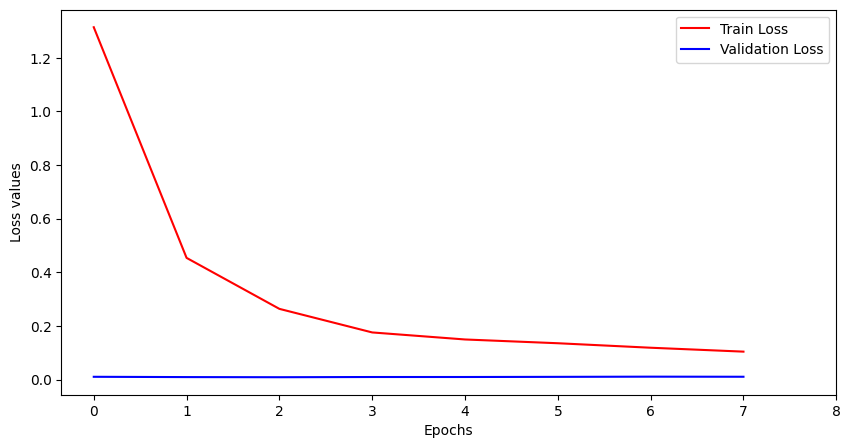

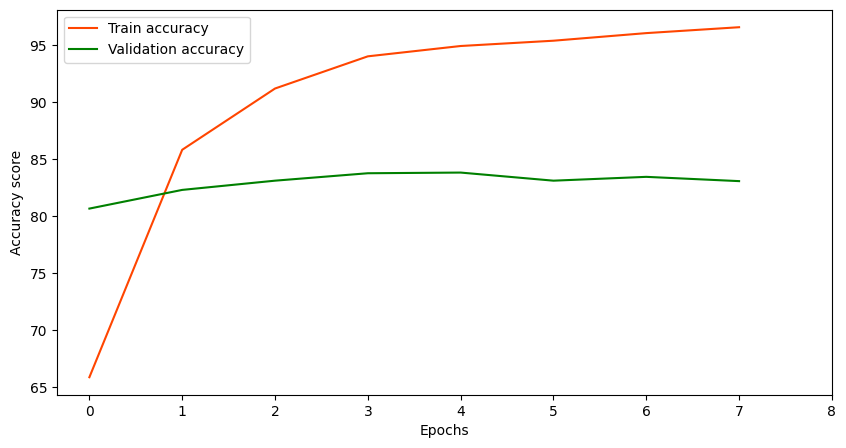

In [16]:
class PlotLearningcurves:
    
    def __init__(self, tr_loss, vl_loss, tr_acc, vl_acc):
        
        self.tr_loss, self.vl_loss, self.tr_acc, self.vl_acc = tr_loss, vl_loss, tr_acc, vl_acc

    def draw(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1)
        plt.plot(array_2, label = label_2, c = color_2)

    def create_plot(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_acc) +1), labels = [i for i in range(len(self.tr_acc) + 1)])
        plt.legend()
        plt.show()
    def demonstrate(self):
        self.create_plot()
        self.draw(array_1 = self.tr_loss, array_2 = self.vl_loss, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = 'red', color_2 = 'blue'); self.decorate(ylabel = "Loss values")

        self.create_plot()
        self.draw(array_1 = self.tr_acc, array_2 = self.vl_acc, label_1 = "Train accuracy", label_2 = "Validation accuracy", color_1 = "orangered", color_2 = "green"); self.decorate(ylabel = "Accuracy score")

PlotLearningcurves(tr_loss = train_losses, vl_loss = vl_losses, tr_acc = train_acces, vl_acc = vl_acces).demonstrate()

### Inference

{'val\\abiu': 0, 'val\\acai': 1, 'val\\acerola': 2, 'val\\ackee': 3, 'val\\ambarella': 4, 'val\\apple': 5, 'val\\apricot': 6, 'val\\avocado': 7, 'val\\banana': 8, 'val\\barbadine': 9, 'val\\barberry': 10, 'val\\betel_nut': 11, 'val\\bitter_gourd': 12, 'val\\black_berry': 13, 'val\\black_mullberry': 14, 'val\\brazil_nut': 15, 'val\\camu_camu': 16, 'val\\cashew': 17, 'val\\cempedak': 18, 'val\\chenet': 19, 'val\\cherimoya': 20, 'val\\chico': 21, 'val\\chokeberry': 22, 'val\\cluster_fig': 23, 'val\\coconut': 24, 'val\\corn_kernel': 25, 'val\\cranberry': 26, 'val\\cupuacu': 27, 'val\\custard_apple': 28, 'val\\damson': 29, 'val\\dewberry': 30, 'val\\dragonfruit': 31, 'val\\durian': 32, 'val\\eggplant': 33, 'val\\elderberry': 34, 'val\\emblic': 35, 'val\\feijoa': 36, 'val\\fig': 37, 'val\\finger_lime': 38, 'val\\gooseberry': 39, 'val\\goumi': 40, 'val\\grape': 41, 'val\\grapefruit': 42, 'val\\greengage': 43, 'val\\grenadilla': 44, 'val\\guava': 45, 'val\\hard_kiwi': 46, 'val\\hawthorn': 47, 

C:\Users\Nodir\AppData\Local\Temp\ipykernel_7712\1461550451.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode = torch.load("best_model/_fruits_best_model.pth", map_l

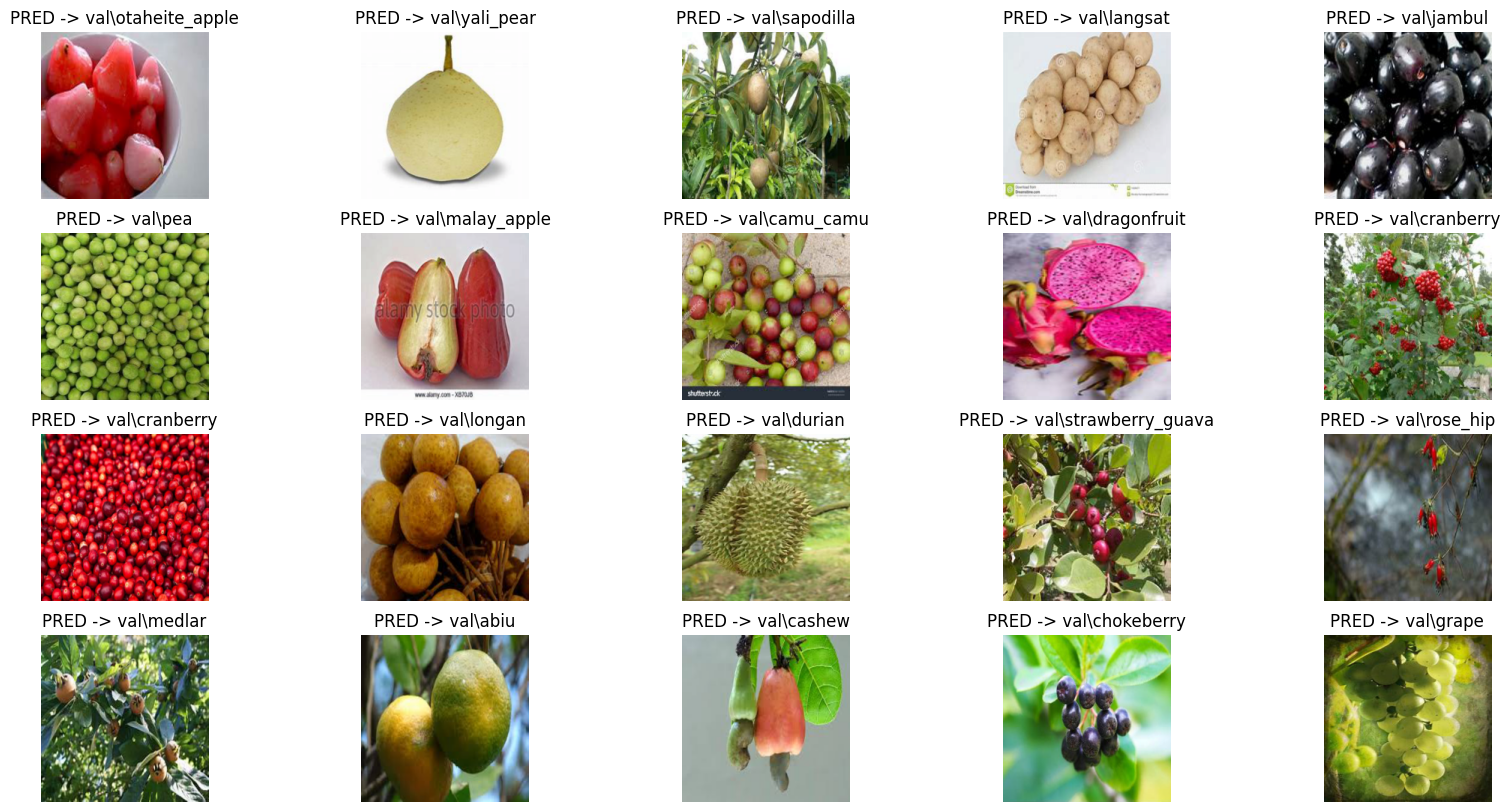

In [80]:
from glob import glob
import os

data = ['val']
root = "datasets/fruits"

# Collect all image paths from train, val, and test
im_paths = []
for split in data:
    im_paths.extend(sorted(glob(f"{root}/{split}/*/*")))

class_names = {}
count = 0

for im_path in im_paths:
    class_name = os.path.dirname(im_path).split("/")[-1]
    if class_name not in class_names:
        class_names[class_name] = count
        count += 1

print(class_names)
    
def inference(model, device, ts_dl, num_ims, row, class_names = None):
    
    preds, images = [], []
    for idx, data in enumerate(ts_dl):
        im = data
        im = im.to(device)
        pred_class = torch.argmax(model(im), dim = 1)
        images.append(im)
        preds.append(pred_class.item())
       

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        if class_names is not None: plt.title(f"PRED -> {class_names[int(preds[indeks])]}")
        else: plt.title(f"PRED -> {pred}")

torch.cuda.empty_cache()
mode = torch.load("best_model/_fruits_best_model.pth", map_location=device)
mode.eval()
inference(mode.to(device), device, ts_dl, 20, 4, list(class_names.keys()))
